## What is correlation?

Correlation is a statistical measure that describes the strength and direction of association between two variables. It tells us how variables move together, but it does not imply a cause–effect relationship. In other words, **correlation does not mean causation**; two variables can be highly correlated due to coincidence, confounding factors, or indirect relationships.

### Linear vs non-linear correlation

When we talk about correlation, we usually mean a linear relationship between variables. Linear correlation measures how well a straight line can describe the relationship. However, many real-world relationships are non-linear, and linear correlation may fail to detect them even when a strong dependency exists.

To capture non-linear or monotonic relationships, alternative measures can be used, such as:

- Spearman rank correlation

- Kendall’s tau

- Mutual information

- Distance correlation

These methods go beyond strict linearity and can detect more general forms of dependence.

---

### How to identify linear vs non-linear relationships

To decide whether two variables are linearly related:

- **Visual inspection** using scatter plots is often the first step.

- A roughly straight-line pattern suggests a linear relationship.

- Curved, clustered, or monotonic-but-nonlinear patterns indicate that non-linear measures may be more appropriate.

Based on this observation:

- Use **Pearson correlation** for linear relationships.

- Use **Spearman** or **Kendall** for monotonic but non-linear relationships.

- Use **mutual information** or **distance correlation** when the relationship is complex or unknown.

---

#### Computing correlation in practice

In pandas, correlation can be computed easily using the corr() function.
By default, pandas uses Pearson correlation, but this can be changed:

- `method="pearson"` → linear correlation (default)

- `method="spearman"` → rank-based, monotonic correlation

- `method="kendall"` → ordinal, robust correlation

---

### Correlation-based feature filtering

In feature selection, we aim to keep variables that are:

- Highly correlated with the target variable, and

- Weakly correlated with other predictor variables

---

### Why highly correlated features are problematic

Highly correlated features do not necessarily reduce predictive accuracy. Many models can still perform well when redundant features are present. However, keeping them can introduce several problems:

- **Curse of dimensionality**: Redundant features increase the effective dimensionality of the dataset without adding new information.

- **Computational inefficiency**: More features lead to higher training and inference costs.

- **Interpretability issues**: Correlated features make it difficult to understand individual feature effects, especially in linear models where coefficients become unstable.

---


### Formulas

**Pearson correlation (linear)**

$$
\rho_{X,Y}
=
\frac{\operatorname{Cov}(X,Y)}
{\sigma_X \, \sigma_Y}
=
\frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2}
\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}
$$

---

**Spearman rank correlation (monotonic, non-linear)**

$$
\rho_s
=
\rho(\operatorname{rank}(X), \operatorname{rank}(Y))
=
1 - \frac{6 \sum_{i=1}^{n} d_i^2}{n(n^2 - 1)}
$$

where $d_i$ is the difference between ranks. To find ranks, sort them and then rank. `Smallest value → rank 1, next → rank 2, etc`. If values are tied, assign them the average rank of the positions they occupy. For example, if value for variable x is the same and the smallest they rank $1$ and $2$ initially but we will asign $1.5$.

---

**Kendall’s tau (ordinal association)**

$$
\tau
=
\frac{n_c - n_d}
{\frac{1}{2} n (n - 1)}
$$

- $n_c$ = number of concordant pairs

- $n_d$ = number of discordant pairs

- $n$ = total number of observations

Consider all possible pairs of observations $(𝑖, 𝑗)$ with $𝑖 < 𝑗$:

- **Concordant pair**: The ranks of both variables move in the same direction.
  Example: if $X_i < X_j$ then $Y_i < Y_j$ or vice versa

- **Discordant pair**: The ranks move in opposite directions.
  Example: if $X_i > X_j$ then $Y_i < Y_j$ or vice versa

**Intuition**

- $\tau = + 1$ → all pairs are concordant (perfect agreement)

- $\tau = −1$ → all pairs are discordant (perfect disagreement)

- $\tau = 0$ → roughly as many concordant as discordant pairs (no association)

---

**Mutual information (general dependence)**

$$
I(X;Y)
=
\sum_{x \in X} \sum_{y \in Y}
p(x,y)\log\left(\frac{p(x,y)}{p(x)p(y)}\right)
$$

the p terms are probability distributions:

- $p(x)$ → the marginal probability of $X=x$

- $p(y)$ → the marginal probability of $Y=y$

- $p(x,y)$ → the joint probability of $X=x$ and $Y=y$

**Intuition**

- $p(x,y)$ tells us how often $X$ and $Y$ occur together.

- $p(x)p(y)$ tells us how often they would occur together if independent.

Mutual information measures the difference between the observed joint distribution and what we’d expect if they were independent.

For a discrete variable X with n samples:

- Marginal probabilities

  $$
  p(x) = \frac{\text{count of samples where X = x}}{n}
  $$

  $$
  p(y) = \frac{\text{count of samples where Y = y}}{n}
  $$

- Joiny probability
  $$
  p(x,y) = \frac{\text{count of samples where X = x and Y = y}}{n}
  $$

In Python, we use:

```python
# Marginal probabilities
p_X = df['X'].value_counts(normalize=True)
p_Y = df['Y'].value_counts(normalize=True)

# Joint probability
p_XY = df.groupby(['X','Y']).size() / len(df)

```

---

**Distance correlation (linear + non-linear)**

$$
\operatorname{dCor}(X,Y)
=
\frac{\operatorname{dCov}(X,Y)}
{\sqrt{\operatorname{dVar}(X)\operatorname{dVar}(Y)}}
$$

with

$$
\operatorname{dCov}^2(X,Y)
=
\frac{1}{n^2}
\sum_{i,j} A_{ij} B_{ij}
$$

where $A_{ij} = |x_i - x_j|$ and $B_{ij} = |y_i - y_j|$ are double-centered distance matrices.

---


## Scanning features

**Brute-force pairwise correlation scanning**

- Compare each feature one by one against all others.

- Remove features that are highly correlated with others.

- _Caution: This method may remove a feature with higher predictive power if it is compared after a less informative correlated feature. Order matters._

**Greedy correlation-based feature grouping (order-dependent)**

- Identify groups of highly correlated features.

- Within each group, select the best representative feature.

- Selection can be based on:

  - Predictive power using a machine learning model (e.g., feature importance from trees or coefficients from linear models)
  - Variance or information content

- This method reduces redundancy while preserving the most informative features in each correlated group.


## Brute-force pairwise correlation scanning


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

df = load_breast_cancer()
X = pd.DataFrame(data=df.data, columns=df.feature_names)
y = pd.DataFrame(data=df.target)

In [2]:
X = X.select_dtypes(exclude=['object'])

X_train, X_test, y_trian, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

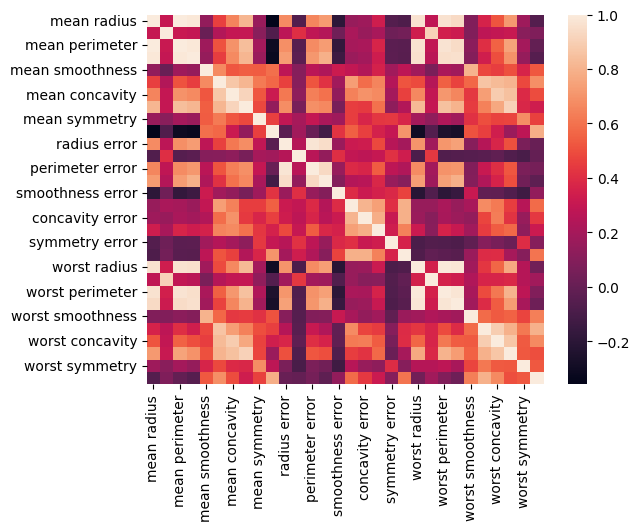

In [3]:
corr_matrix = X_train.corr(method='pearson')
sns.heatmap(corr_matrix)
plt.show()

In [4]:
threshold = 0.8
high_corr = [(i, j) for i in corr_matrix.columns 
                     for j in corr_matrix.columns 
                     if i != j and abs(corr_matrix.loc[i,j]) > threshold]

high_corr

[('mean radius', 'mean perimeter'),
 ('mean radius', 'mean area'),
 ('mean radius', 'mean concave points'),
 ('mean radius', 'worst radius'),
 ('mean radius', 'worst perimeter'),
 ('mean radius', 'worst area'),
 ('mean texture', 'worst texture'),
 ('mean perimeter', 'mean radius'),
 ('mean perimeter', 'mean area'),
 ('mean perimeter', 'mean concave points'),
 ('mean perimeter', 'worst radius'),
 ('mean perimeter', 'worst perimeter'),
 ('mean perimeter', 'worst area'),
 ('mean area', 'mean radius'),
 ('mean area', 'mean perimeter'),
 ('mean area', 'mean concave points'),
 ('mean area', 'worst radius'),
 ('mean area', 'worst perimeter'),
 ('mean area', 'worst area'),
 ('mean smoothness', 'worst smoothness'),
 ('mean compactness', 'mean concavity'),
 ('mean compactness', 'mean concave points'),
 ('mean compactness', 'worst compactness'),
 ('mean compactness', 'worst concavity'),
 ('mean compactness', 'worst concave points'),
 ('mean concavity', 'mean compactness'),
 ('mean concavity', 'me

In [5]:
# columns to be removed

high_corr_cols = {pair[0] for pair in high_corr}
high_corr_cols

{'area error',
 'compactness error',
 'concavity error',
 'mean area',
 'mean compactness',
 'mean concave points',
 'mean concavity',
 'mean perimeter',
 'mean radius',
 'mean smoothness',
 'mean texture',
 'perimeter error',
 'radius error',
 'worst area',
 'worst compactness',
 'worst concave points',
 'worst concavity',
 'worst perimeter',
 'worst radius',
 'worst smoothness',
 'worst texture'}

In [6]:
X_train = X_train.drop(columns=high_corr_cols, axis=1)
X_test = X_test.drop(columns=high_corr_cols, axis=1)

**Decide which feature to remove**

Common strategies:

- Remove the feature with lower correlation to the target.

- Remove the feature with more missing values.

- Remove one randomly (less recommended).

#### Industry considerations

- Threshold selection: 0.8–0.95 depending on domain; higher thresholds are more conservative.

- Scalability: Works well for small to medium feature sets (<500–1000 features).

- Automated pipelines: Often wrapped in feature selection pipelines (e.g., sklearn.feature_selection) to ensure reproducibility.

- Monitoring: Logging which features were dropped is important for interpretability and auditing.


## Greedy correlation-based feature grouping (order-dependent)


In [7]:
corr_matrix = X_train.corr()
corr_pairs = corr_matrix.abs().unstack()
corr_pairs = corr_pairs.sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs > 0.8]
corr_pairs = pd.DataFrame(corr_pairs).reset_index(drop=False)
corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]
corr_pairs

,Feature 1,Feature 2,Correlation
0,mean symmetry,mean symmetry,1.0
1,mean fractal dimension,mean fractal dimension,1.0
2,worst symmetry,worst symmetry,1.0
3,fractal dimension error,fractal dimension error,1.0
4,symmetry error,symmetry error,1.0
5,smoothness error,smoothness error,1.0
6,texture error,texture error,1.0
7,concave points error,concave points error,1.0
8,worst fractal dimension,worst fractal dimension,1.0


In [8]:
# Find correlated feature groups
visited = set()
correlated_groups = []

for f1 in corr_pairs["Feature 1"].unique():
    if f1 not in visited:

        f1_correlated_block = corr_pairs[corr_pairs["Feature 1"] == f1].reset_index(drop=True)

        visited.update(
            [f1] + list(f1_correlated_block["Feature 2"].unique())
        )

        correlated_groups.append(f1_correlated_block)

print(f"Found {len(correlated_groups)} correlated groups")


Found 9 correlated groups


In [9]:
X_train.isna().sum(axis=0)

mean symmetry              0
mean fractal dimension     0
texture error              0
smoothness error           0
concave points error       0
symmetry error             0
fractal dimension error    0
worst symmetry             0
worst fractal dimension    0
dtype: int64

When multiple features are highly correlated, only one should be kept. A common criterion is to retain the feature with fewer missing values, but this is not applicable here since the dataset has none. Another practical approach is to train a model using all correlated features and keep the one with the highest predictive power.


In [10]:
from sklearn.ensemble import RandomForestClassifier

# Let's start with the first group as an example
features = np.unique(correlated_groups[0][['Feature 1', 'Feature 2']].values.flatten())

rf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=4)
rf.fit(X_train[features], y_trian)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

In [11]:
pd.DataFrame(data={'Features': features, 'Importance': rf.feature_importances_})

,Features,Importance
0,mean symmetry,1.0


In this example, feature `mean smoothness` has the highest importance according to the random forest model, so it is retained while the other features in the same correlated group are removed from the dataset. However, neither of the two correlation-based feature removal procedures is perfect, and some correlated features may remain after the first pass. **Therefore, it is good practice to recheck the dataset for remaining correlated features and repeat the process if necessary.**


**Binary columns should not always be handled the same way as continuous numeric columns.**

### Handeling binary columns

- Exclude binary–binary and binary–numeric pairs from Pearson correlation

- Compute correlation only on continuous numeric features

- Binary features should be handled later via model-based selection


In [12]:
# Detect binary vs continuous numeric features

binary_features = [col for col in features if X_train[col].nunique() == 2]
continuous_features = [col for col in features if col not in binary_features]

In [13]:
binary_features

[]